# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [7]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/' # adjust to match location of this Dryad repo folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Extended Data Fig. 2 notebook save_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' 

In [8]:
''' Get reward & lick data for sessions w/ neural data'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        #print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        #print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

In [9]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
                               
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

In [10]:
''' Load indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded.

Generated in Extended Data Fig. 2 notebook. Please run that before proceeding.

''' 

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
        
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        Aidx = np.load(figs2_folder + Aidx_file)
        Bidx = np.load(figs2_folder + Bidx_file)
        A_idx = np.load(figs2_folder + A_idx_file)
        B_idx = np.load(figs2_folder + B_idx_file)
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx

        #Also load A`& B` indices excluding gain change trials in each context
        A_ngidx = np.load(figs2_folder + A_ngidx_file)
        B_ngidx = np.load(figs2_folder + B_ngidx_file)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx

In [11]:
''' Gather total number of SM cells'''

young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


# Load classified grid, non-grid spatial, and spatial cells in Extended Data Fig. 2.

In [12]:
''' In the Extended Data Fig. 2 notebook, you previously classified grid & ngs cells. Load saved grid & ngs cell booleans.

If you did not, run Extended Data Fig. 2 notebook before proceeding.

'''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')

        #load spatial cells & interneuron booleans
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        d['spatialcell99'] = np.load(figs2_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        
        #load grid & NGS cell booleans
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(figs2_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(figs2_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


In [13]:
''' Get counts of grid vs ngs cells by age group '''

ygrid = 0
magrid = 0
agrid = 0

yngs = 0
mangs = 0
angs = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        if m in SM_aged_mice:
            agrid += np.sum(gridcell)
            angs += np.sum(ngscell)
        elif m in SM_MA_mice:
            magrid += np.sum(gridcell)
            mangs += np.sum(ngscell)
        else:
            ygrid += np.sum(gridcell)
            yngs += np.sum(ngscell)
            
print(ygrid, magrid, agrid)
print(yngs, mangs, angs)

2441 2035 2032
2154 2347 2058


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
14.8296889586848 0.6177677242640354 15.167797844277539 0.5583139064062825


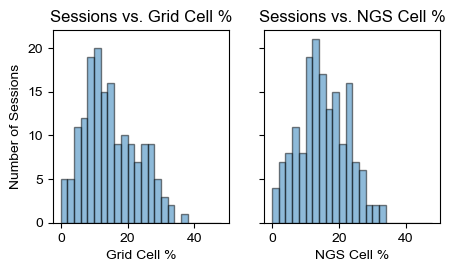

In [14]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [15]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [16]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mpergrid[y_ind], mpergrid[ma_ind], mpergrid[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Take a look at grid cells' waveform metrics across age groups if curious

In [17]:
metrics_folder = 'C:/Users/Python/Desktop/Dryad/waveform_metrics/' # adjust to match location of this Dryad repo folder

In [53]:
''' Gather Session Average IN Waveform Properties by Age Group '''

# pooling arrays
PTRa = []
PTRma = []
PTRy = []
FRa = []
FRma = []
FRy = []
widtha = []
widthma = []
widthy = []
durationa = []
durationma = []
durationy = []
amplitudea = []
amplitudema = []
amplitudey = []
recslopea = []
recslopema = []
recslopey = []

#session arrays
sPTR = []
sFR = []
sduration = []
swidth = []
sgrid = []
samplitude = []
srecslope = []
mgrid = []

allwidth = []
allduration = []
allFR = []
allamplitude = []
allrecslope = []

for m, session in zip(mice,sessions):
    
    seshcount = 1 #should actually be 1 
    grids = []
    cells = []
    widths = []
    durations = []
    amplitudes = []
    recslopes = []
    frs = []
    
    for s in tdqm(session):
        d = data[m][s]
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        metric_file_name = m + '_' + str(seshcount) + '_metrics.csv'
        cell_IDs = raw.item().get('cellsfil')
        
        # load waveform parameters of interest for good cells only
        metrics = pd.read_csv(metrics_folder + metric_file_name)
        gcmetrics = metrics[metrics['cluster_id'].isin(list(cell_IDs))]
        amplitude = np.asarray(gcmetrics['amplitude'])
        duration = np.asarray(gcmetrics['duration'])
        PTR = np.asarray(gcmetrics['PT_ratio'])
        halfwidth = np.asarray(gcmetrics['halfwidth'])
        recslope = np.asarray(gcmetrics['recovery_slope'])
        firingrate = np.asarray(gcmetrics['firing_rate'])
        
        #get file name & load int file
        gridcell = d['gridcell'].astype(bool)
        
        grids = np.append(grids, np.sum(gridcell))
        cells = np.append(cells, len(cell_IDs))
        
        sgrid = np.append(sgrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        if np.sum(gridcell) > 0: 
        
            #collect data to be pooled across animals        
            widths = np.append(widths, halfwidth[gridcell])
            durations = np.append(durations, duration[gridcell])
            frs = np.append(frs, firingrate[gridcell])
            amplitudes = np.append(amplitudes, amplitude[gridcell])
            recslopes = np.append(recslopes, recslope[gridcell])

            #save out session values
            sPTR = np.append(sPTR, np.mean(PTR[gridcell]))
            sFR = np.append(sFR, np.mean(firingrate[gridcell]))
            swidth = np.append(swidth, np.nanmean(halfwidth[gridcell]))
            sduration = np.append(sduration, np.mean(duration[gridcell]))
            samplitude = np.append(samplitude, np.mean(amplitude[gridcell]))
            srecslope = np.append(srecslope, np.nanmean(recslope[gridcell]))

            #collect data to be pooled across all sessions, animals in age groups
            if m in all_aged_mice:
                PTRa = np.append(PTRa, PTR[gridcell])
                FRa = np.append(FRa, firingrate[gridcell])
                widtha = np.append(widtha, halfwidth[gridcell])
                durationa = np.append(durationa, duration[gridcell])
                amplitudea = np.append(amplitudea, amplitude[gridcell])
                recslopea = np.append(recslopea, recslope[gridcell])
            elif m in all_MA_mice:
                PTRma = np.append(PTRma, PTR[gridcell])
                FRma = np.append(FRma, firingrate[gridcell])
                widthma = np.append(widthma, halfwidth[gridcell])
                durationma = np.append(durationma, duration[gridcell])
                amplitudema = np.append(amplitudema, amplitude[gridcell])
                recslopema = np.append(recslopema, recslope[gridcell])
            else:
                PTRy = np.append(PTRy, PTR[gridcell])
                FRy = np.append(FRy, firingrate[gridcell])
                widthy = np.append(widthy, halfwidth[gridcell])
                durationy = np.append(durationy, duration[gridcell])
                amplitudey = np.append(amplitudey, amplitude[gridcell])
                recslopey = np.append(recslopey, recslope[gridcell])
        
            seshcount += 1
        else:
            sPTR = np.append(sPTR, np.nan)
            sFR = np.append(sFR, np.nan)
            swidth = np.append(swidth, np.nan)
            sduration = np.append(sduration, np.nan)
            samplitude = np.append(samplitude, np.nan)
            srecslope = np.append(srecslope, np.nan)
            
            seshcount += 1
        
    mgrid = np.append(mgrid, (100* np.sum(grids) / np.sum(cells)))
    allwidth = np.append(allwidth, widths)
    allduration = np.append(allduration, durations)
    allFR = np.append(allFR, frs)
    allamplitude = np.append(allamplitude, amplitudes)
    allrecslope = np.append(allrecslope,recslopes)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
''' Find where I will have NaNs due to 0% grid cells in a given session'''
nan_idx = np.where((sgrid == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idx)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idx)
age_sindgrid = np.setdiff1d(age_sind, nan_idx)

# Adjust colormaps for all thresholds
yidx = []
maidx = []
aidx = []
for i in nan_idx:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid]      

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

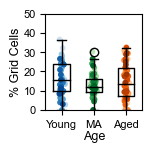

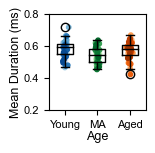

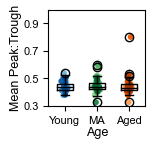

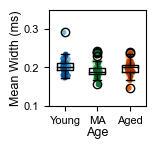

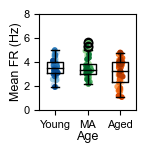

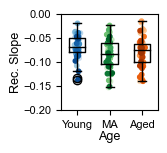

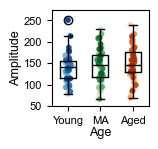

In [57]:
''' Plot Grid Density & Waveform Properties '''

# set up handles
from itertools import repeat
handles = []
percgrid = [mgrid[y_ind], mgrid[ma_ind], mgrid[age_ind]]
for i in range(len(percgrid)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))

#Plot Extended Data Fig. 6d (first)
fig, ax = plt.subplots(figsize = (1.25,1.25))
percgrid = [sgrid[y_sind], sgrid[ma_sind], sgrid[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(percgrid, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(percgrid)):
    y = percgrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i][:len(y)], edgecolors = col_session[i][:len(y)], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Grid Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.show()

#Plot Extended Data Fig. 6D (second)
fig, ax = plt.subplots(figsize = (1.25,1.25))
griddur = [sduration[y_sindgrid], sduration[ma_sindgrid], sduration[age_sindgrid]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(griddur, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(griddur)):
    y = griddur[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Duration (ms)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.2,0.8])
ax.set_yticks([0.2,0.4,0.6,0.8])
plt.show()

#Plot Extended Data Fig. 6D (middle)
fig, ax = plt.subplots(figsize = (1.25,1.25))
gridPTR = [sPTR[y_sindgrid], sPTR[ma_sindgrid], sPTR[age_sindgrid]]
plt.boxplot(gridPTR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(gridPTR)):
    y = gridPTR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Peak:Trough', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.3, 1.0])
ax.set_yticks([0.3,0.50,0.7,0.9])
plt.show()

#Plot Extended Data Fig. 6D (fourth)
fig, ax = plt.subplots(figsize = (1.25,1.25))
gridwidth = [swidth[y_sindgrid], swidth[ma_sindgrid], swidth[age_sindgrid]]
plt.boxplot(gridwidth, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(gridwidth)):
    y = gridwidth[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Width (ms)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.10,0.35])
ax.set_yticks([0.10,0.2,0.30])
plt.show()

#Plot Extended Data Fig. 6D (last)
fig, ax = plt.subplots(figsize = (1.25,1.25))
gridFR = [sFR[y_sindgrid], sFR[ma_sindgrid], sFR[age_sindgrid]]
plt.boxplot(gridFR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(gridFR)):
    y = gridFR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean FR (Hz)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,8])
ax.set_yticks([0,2,4,6,8])
plt.show()

fig, ax = plt.subplots(figsize = (1.25,1.25))
gridFR = [srecslope[y_sindgrid], srecslope[ma_sindgrid], srecslope[age_sindgrid]]
plt.boxplot(gridFR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(gridFR)):
    y = gridFR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Rec. Slope', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.2,0])
ax.set_yticks([-0.2,-0.15,-0.1,-0.05,0])
plt.show()


fig, ax = plt.subplots(figsize = (1.25,1.25))
gridFR = [samplitude[y_sindgrid], samplitude[ma_sindgrid], samplitude[age_sindgrid]]
plt.boxplot(gridFR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(gridFR)):
    y = gridFR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Amplitude', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([50,275])
ax.set_yticks([50,100,150,200,250])
plt.show()

In [59]:
'''Statistics for Multiple Comparisons for grid Waveform Duration (Extended Data Fig. 6D (second))'''

print('\nn young, MA, aged w/ grids: ')
print(len(y_sindgrid),len(ma_sindgrid), len(age_sindgrid))

print('\nDurationyoung ± SEM; Duration_MA ± SEM; Duration_old ± SEM')
print(str(np.round(np.mean(sduration[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sduration[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sduration[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[age_sindgrid]), 4)))

stat, p_diff = stats.kruskal(sduration[y_sindgrid],sduration[ma_sindgrid],sduration[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_durationsession = ' + str(p_diff))

import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindgrid,ma_sindgrid,age_sindgrid))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Duration = list(sduration[allidx])
PTR = list(sPTR[allidx])
Width = list(swidth[allidx])
Meanfr = list(sFR[allidx])
Amplitude = list(samplitude[allidx])
Recslope = list(srecslope[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Duration, PTR, Width, Meanfr, Amplitude, Recslope))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','duration','ptr','width', 'meanfr', 'amp', 'recslope'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'duration', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, aged w/ grids: 
53 57 53

Durationyoung ± SEM; Duration_MA ± SEM; Duration_old ± SEM
0.5791 ± 0.007 ; 0.5425 ± 0.0067 ; 0.5701 ± 0.0072
KW stat = 14.369768415102214
p_durationsession = 0.0007579567685291334


,1.0,2.0,3.0
1.0,1.000000,0.000738,0.394528
2.0,0.000738,1.000000,0.008992
3.0,0.394528,0.008992,1.000000


In [60]:
print('\nPTRyoung ± SEM; PTR_MA ± SEM; PTR_old ± SEM')
print(str(np.round(np.mean(sPTR[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sPTR[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sPTR[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[age_sindgrid]), 4)))

stat, p_diff = stats.kruskal(sPTR[y_sindgrid],sPTR[ma_sindgrid],sPTR[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_PTRsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'ptr', group_col = 'AgeGroup', p_adjust = 'holm')


PTRyoung ± SEM; PTR_MA ± SEM; PTR_old ± SEM
0.4417 ± 0.0049 ; 0.4469 ± 0.0062 ; 0.4443 ± 0.0085
KW stat = 0.9024266911508789
p_PTRsession = 0.6368549574959216


,1.0,2.0,3.0
1.0,1.0,1.0,1.0
2.0,1.0,1.0,1.0
3.0,1.0,1.0,1.0


In [61]:
print('\nWidthyoung ± SEM; Width_MA ± SEM; Width_old ± SEM')
print(str(np.round(np.mean(swidth[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(swidth[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(swidth[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[age_sindgrid]), 4)))

stat, p_diff = stats.kruskal(swidth[y_sindgrid],swidth[ma_sindgrid],swidth[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_widthsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'width', group_col = 'AgeGroup', p_adjust = 'holm')


Widthyoung ± SEM; Width_MA ± SEM; Width_old ± SEM
0.2031 ± 0.0026 ; 0.1931 ± 0.0023 ; 0.2027 ± 0.0046
KW stat = 12.07038090022923
p_widthsession = 0.0023930407290660986


,1.0,2.0,3.0
1.0,1.000000,0.002133,0.362582
2.0,0.002133,1.000000,0.025231
3.0,0.362582,0.025231,1.000000


In [62]:
print('\nFRyoung ± SEM; FR_MA ± SEM; FR_old ± SEM')
print(str(np.round(np.mean(sFR[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFR[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFR[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[age_sindgrid]), 4)))

stat, p_diff = stats.kruskal(sFR[y_sindgrid],sFR[ma_sindgrid],sFR[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_FRsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'meanfr', group_col = 'AgeGroup', p_adjust = 'holm')


FRyoung ± SEM; FR_MA ± SEM; FR_old ± SEM
3.4719 ± 0.0967 ; 3.5445 ± 0.1137 ; 3.142 ± 0.143
KW stat = 2.530268072616309
p_FRsession = 0.282201468362457


,1.0,2.0,3.0
1.0,1.000000,0.995689,0.49144
2.0,0.995689,1.000000,0.49144
3.0,0.491440,0.491440,1.00000


In [63]:
print('\namplitudeyoung ± SEM; amplitude_MA ± SEM; amplitude_old ± SEM')
print(str(np.round(np.mean(samplitude[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(samplitude[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(samplitude[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(samplitude[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(samplitude[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(samplitude[age_sindgrid]), 4)))

stat, p_diff = stats.kruskal(samplitude[y_sindgrid],samplitude[ma_sindgrid],samplitude[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_amplitudesession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'amp', group_col = 'AgeGroup', p_adjust = 'holm')


amplitudeyoung ± SEM; amplitude_MA ± SEM; amplitude_old ± SEM
138.8715 ± 4.3743 ; 144.4254 ± 4.95 ; 150.1986 ± 5.6931
KW stat = 2.233215018438216
p_amplitudesession = 0.32738857551936146


,1.0,2.0,3.0
1.0,1.000000,0.744554,0.417043
2.0,0.744554,1.000000,0.744554
3.0,0.417043,0.744554,1.000000


In [64]:
print('\nrecslopeyoung ± SEM; recslope_MA ± SEM; recslope_old ± SEM')
print(str(np.round(np.mean(srecslope[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(srecslope[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(srecslope[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(srecslope[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(srecslope[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(srecslope[age_sindgrid]), 4)))

stat, p_diff = stats.kruskal(srecslope[y_sindgrid],srecslope[ma_sindgrid],srecslope[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_recslopesession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'recslope', group_col = 'AgeGroup', p_adjust = 'holm')


recslopeyoung ± SEM; recslope_MA ± SEM; recslope_old ± SEM
-0.0692 ± 0.0033 ; -0.083 ± 0.0041 ; -0.079 ± 0.004
KW stat = 6.772311015767116
p_recslopesession = 0.03383851907084689


,1.0,2.0,3.0
1.0,1.000000,0.033783,0.131392
2.0,0.033783,1.000000,0.498983
3.0,0.131392,0.498983,1.000000


# Plot figures visualizing spatial firing patterns relative to VR contexts & verifying classification of grid vs. NGS cells (Figures 2A-E & S3A-E)

Not required to run subsequent sections of this notebook.

  0%|          | 0/6 [00:00<?, ?it/s]

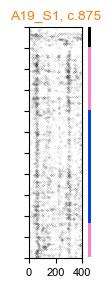

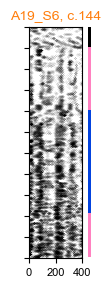

  0%|          | 0/6 [00:00<?, ?it/s]

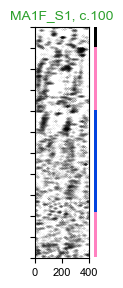

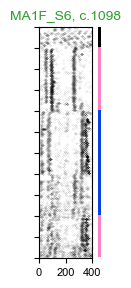

  0%|          | 0/6 [00:00<?, ?it/s]

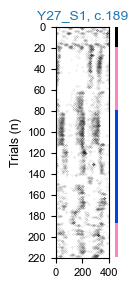

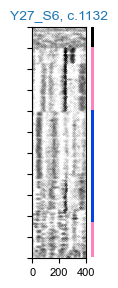

In [30]:
''' Sequentially Plot Example Grid Cell Rasters (Figure 2A)'''

switches = [-20, -80]
colors = ['xkcd:pink','xkcd:blue']
labels = ['Context A','Context B']
CLU_W = 3

from matplotlib.lines import Line2D
from copy import copy
count = 0
cellcount = 0

ex_mice = ['Y27','MA1F','A19'] # mouse names for Fig 2 / S3 examples
ex_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6',
               '012723_record2','020123_record7'] #list of sssions

ex_gridcells = [875,144,100,1098,189,1132]
minimalistbool = [True,True,True,True,False,True]
sesh = [1,6,1,6,1,6]
cols = ['C1','C1','C2','C2','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue 
            
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posx = behaviorfil[:,0]
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        rawtrialfil = raw.item().get('trialfil')
        trial = behaviorfil[:,2]
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        trials = np.unique(trial)
        alltrial = np.arange(0, 220 ,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])

        #Reverse y-axis
        skippedrawtrialfil = -1 * skippedrawtrialfil
        newskippedtrials = -1 * newskippedtrials

        ## PLOT RASTER w/ CONTEXT LABEL
        c = ex_gridcells[cellcount]
        minimalist = minimalistbool[cellcount]
        col = cols[cellcount]
        
        widths = [20,1]
        heights = [1]
        fig = plt.figure(figsize = (0.8,3))
        gs = gridspec.GridSpec(ncols = 2, nrows = 1, figure=fig, height_ratios = heights, width_ratios = widths)

        sdx = Z[:, np.where(cell_IDs == c)[0][0]].astype(bool)
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(posxcopy[sdx], skippedrawtrialfil[sdx], '.', color = 'k', markersize=0.2, alpha=0.4)
        ax1.set_xlim([0, 400])
        ax1.set_ylim([np.min(skippedrawtrialfil),0])
        ax1.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax1.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        ax1.set_xticks([0,200,400])
        ax1.tick_params(labelsize = 8)
        ax1.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 10, color = col)

        if minimalist == False:
            ax1.set_ylabel('Trials (n)', fontsize = 9)
        else:
            ax1.set_yticklabels([])

        #label skipped trials for transparency
        for z in newskippedtrials:
            ax1.hlines(z,0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dotted')

        #label dark trials & trial context at right
        ax2 = fig.add_subplot(gs[1], sharey = ax1)
        for i, t in enumerate(context.astype(bool)):
            if i >= 20:
                if i in newskippedtrials:
                    ax2.vlines(0, -1*i, -1*i + 1, colors='lightgrey', lw= CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    if t == True:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            else: 
                ax2.vlines(0, -1*i, -1*i + 1, colors='k', lw= CLU_W, linestyles='solid', alpha = 1)

        ax2.axis('off') 
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '2A.png', dpi = 400)
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '2A.svg', dpi = 400)
        plt.show()
        
        cellcount += 1

  0%|          | 0/6 [00:00<?, ?it/s]

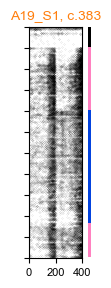

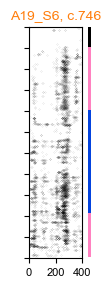

  0%|          | 0/6 [00:00<?, ?it/s]

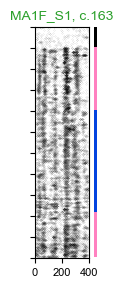

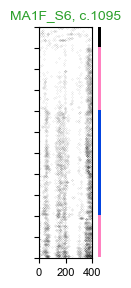

  0%|          | 0/6 [00:00<?, ?it/s]

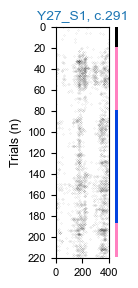

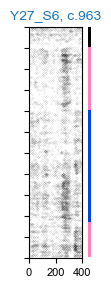

In [31]:
''' Sequentially Plot Example Non-Grid Spatial Cell Rasters (Extended Data Fig. 3A)'''

switches = [-20, -80]
colors = ['xkcd:pink','xkcd:blue']
labels = ['Context A','Context B']
CLU_W = 3

from matplotlib.lines import Line2D
from copy import copy
count = 0
cellcount = 0

ex_mice = ['Y27','MA1F','A19'] # mouse names for Fig 2 / S3 examples
ex_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6',
               '012723_record2','020123_record7'] #list of sssions

ex_ngscells = [383,746,163,1095,291,963]
minimalistbool = [True,True,True,True,False,True]
sesh = [1,6,1,6,1,6]
cols = ['C1','C1','C2','C2','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue 
            
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posx = behaviorfil[:,0]
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        rawtrialfil = raw.item().get('trialfil')
        trial = behaviorfil[:,2]
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        trials = np.unique(trial)
        alltrial = np.arange(0, 220 ,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])

        #Reverse y-axis
        skippedrawtrialfil = -1 * skippedrawtrialfil
        newskippedtrials = -1 * newskippedtrials

        ## PLOT RASTER w/ CONTEXT LABEL
        c = ex_ngscells[cellcount]
        minimalist = minimalistbool[cellcount]
        col = cols[cellcount]
        
        widths = [20,1]
        heights = [1]
        fig = plt.figure(figsize = (0.8,3))
        gs = gridspec.GridSpec(ncols = 2, nrows = 1, figure=fig, height_ratios = heights, width_ratios = widths)

        sdx = Z[:, np.where(cell_IDs == c)[0][0]].astype(bool)
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(posxcopy[sdx], skippedrawtrialfil[sdx], '.', color = 'k', markersize=0.2, alpha=0.4)
        ax1.set_xlim([0, 400])
        ax1.set_ylim([np.min(skippedrawtrialfil),0])
        ax1.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax1.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        ax1.set_xticks([0,200,400])
        ax1.tick_params(labelsize = 8)
        ax1.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 10, color = col)

        if minimalist == False:
            ax1.set_ylabel('Trials (n)', fontsize = 9)
        else:
            ax1.set_yticklabels([])

        #label skipped trials for transparency
        for z in newskippedtrials:
            ax1.hlines(z,0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dotted')

        #label dark trials & trial context at right
        ax2 = fig.add_subplot(gs[1], sharey = ax1)
        for i, t in enumerate(context.astype(bool)):
            if i >= 20:
                if i in newskippedtrials:
                    ax2.vlines(0, -1*i, -1*i + 1, colors='lightgrey', lw= CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    if t == True:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            else: 
                ax2.vlines(0, -1*i, -1*i + 1, colors='k', lw= CLU_W, linestyles='solid', alpha = 1)

        ax2.axis('off') 
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + 'S3A.png', dpi = 400)
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + 'S3A.svg', dpi = 400)
        plt.show()
        
        cellcount += 1

  0%|          | 0/6 [00:00<?, ?it/s]

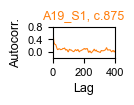

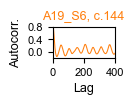

  0%|          | 0/6 [00:00<?, ?it/s]

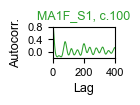

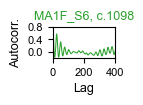

  0%|          | 0/6 [00:00<?, ?it/s]

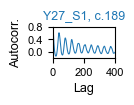

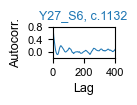

In [36]:
''' Plot dark FR autocorrelation of example grid cells (Figure 2B)'''

cellcount = 0
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        d = data[m][s]
    
        if s not in ex_sessions:
            continue 
            
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')

        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')

        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)

        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'

        # for example cell, calc autocorrelation & plot
        c = ex_gridcells[cellcount]
        col = cols[cellcount]
        sdx = np.where(cell_IDs == c)[0][0]
        autocorrelation = get.autocorr(FR[sdx,:],lags)
        normauto = autocorrelation / autocorrelation[0]

        fig,ax = plt.subplots(figsize = (0.8,0.4))
        ax.plot(lags, normauto, color = col, linewidth = 0.75)
        ax.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 9, color = col)
        ax.set_xlabel('Lag',fontsize = 9)
        ax.set_ylabel('Autocorr.',fontsize = 9)
        ax.set_xlim([0,400])
        ax.set_ylim([-0.2, 0.8])
        ax.set_yticks([0, 0.4, 0.8])
        ax.set_xticks([0,200,400])
        ax.tick_params(labelsize = 8)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + '2B.png', dpi = 400)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + '2B.svg', dpi = 400)
        plt.show()

        cellcount += 1    

  0%|          | 0/6 [00:00<?, ?it/s]

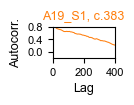

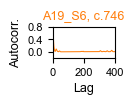

  0%|          | 0/6 [00:00<?, ?it/s]

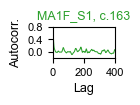

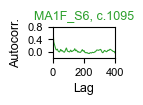

  0%|          | 0/6 [00:00<?, ?it/s]

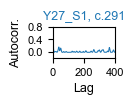

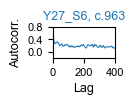

In [37]:
''' Plot dark FR autocorrelation of example non-grid spatial cells (Extended Data Fig. 3B)'''

cellcount = 0

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        d = data[m][s]
    
        if s not in ex_sessions:
            continue 
            
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')

        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')

        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)

        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'

        # for example cell, calc autocorrelation & plot
        c = ex_ngscells[cellcount]
        col = cols[cellcount]
        sdx = np.where(cell_IDs == c)[0][0]
        autocorrelation = get.autocorr(FR[sdx,:],lags)
        normauto = autocorrelation / autocorrelation[0]

        fig, ax = plt.subplots(figsize = (0.8,0.4))
        ax.plot(lags, normauto, color = col, linewidth = 0.75)
        ax.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 9, color = col)
        ax.set_xlabel('Lag',fontsize = 9)
        ax.set_ylabel('Autocorr.',fontsize = 9)
        ax.set_xlim([0,400])
        ax.set_ylim([-0.2, 0.8])
        ax.set_yticks([0, 0.4, 0.8])
        ax.set_xticks([0,200,400])
        ax.tick_params(labelsize = 8)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + 'S3B.png', dpi = 400)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + 'S3B.svg', dpi = 400)
        plt.show()

        cellcount += 1    

In [29]:
''' Choose a random shuffle rep vs. real distribution of all grid & non-grid cell autocorrelation peak heights

Run time <30s / session.

'''

import random
n_dark = 20 #trials
lags = np.arange(0,801,1)

ngsshuffheights = []
gridshuffheights = []

gridproms = []
ngsproms = []
gridheights = []
ngsheights = []

P99shuffheight = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')
        
        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:],lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)
                
        peak = peak.astype(bool)
    
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]  
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder + shufmaxpeak_heights_file)
        
        for i, c in enumerate(cell_IDs):
            idx = np.where(cell_IDs[peak] == c)[0]
            
            if len(idx) == 0:
                P99shuffheight = np.append(P99shuffheight, np.nan)
            else:
                shuffheightP99 = np.percentile(np.ravel(shuffmaxpeak_heights[:,idx]), 99)
                P99shuffheight = np.append(P99shuffheight, shuffheightP99)

        for i, c in enumerate(gridcells):
            idx = np.where(cell_IDs[peak] == c)[0]
            sdx = np.where(cell_IDs == c)[0]
        
            shuffheight = np.random.choice(np.ravel(shuffmaxpeak_heights[:,idx]))
            gridproms = np.append(gridproms, maxpeak_proms[sdx])
            gridheights = np.append(gridheights, maxpeak_heights[sdx])
            gridshuffheights = np.append(gridshuffheights, shuffheight)
            
        for i, c in enumerate(ngscells):
            idx = np.where(cell_IDs[peak] == c)[0]
            sdx = np.where(cell_IDs == c)[0]
            
            if len(idx) > 0:
                shuffheight = np.random.choice(np.ravel(shuffmaxpeak_heights[:,idx]))
            else:
                shuffheight = 0
                
            ngsproms = np.append(ngsproms, maxpeak_proms[sdx])
            ngsheights = np.append(ngsheights, maxpeak_heights[sdx])
            ngsshuffheights = np.append(ngsshuffheights, shuffheight)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\Desktop\GitHub\Herber2024\pipeline\get_data.py:380: RuntimeWarning: invalid value encountered in divide
  corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [30]:
''' Peak Height Thresholds & n model pairs vs. shuffle'''

print('n total cells w/ peaks: ' + str(len(P99shuffheight[~np.isnan(P99shuffheight)])))
print('% total cells w/ significant peaks: ' + str(100*len(P99shuffheight[~np.isnan(P99shuffheight)])/43388))

print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99shuffheight)) + ', ' + str(stats.sem(P99shuffheight, nan_policy = 'omit')))
print('n grid, NGS model pairs: ' + str(len(gridheights)) + ', ' + str(len(ngsheights)))

n total cells w/ peaks: 17498
% total cells w/ significant peaks: 40.329123259887524
mean ± SEM coherence shuffle P99: 0.2017224122142725, 0.0009507379791441329
n grid, NGS model pairs: 6508, 6559


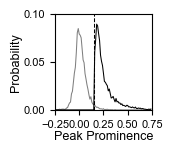

Mean, SEM Real:
0.2534256169200522 0.001305304064766415

Mean, SEM Shuffle:
0.008616505633964228 0.0007578409318702676

stat = 558.0
p_cells = 0.0


In [45]:
'''Plot Figure 2C + Display Stats'''
bins = np.arange(-0.25,0.75,0.01)
gproms, bin_edges = np.histogram(gridproms, bins = bins)
pdf = gproms / sum(gproms)

shuffgheights, shuffbin_edges = np.histogram(gridshuffheights, bins = bins)
shuffpdf = shuffgheights / sum(shuffgheights)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.vlines(0.15,0,0.75, colors ='k', linewidths = 0.75, linestyles = '--')
ax.set_ylabel('Probability', fontsize = 9, labelpad = 1)
ax.set_xlabel('Peak Prominence', fontsize = 9, labelpad = 1)
ax.set_xlim([-0.25,0.75])
ax.set_xticks([-0.25,0,0.25,0.5,0.75])
ax.set_ylim([0, 0.10])
ax.set_yticks([0, 0.05,0.10])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + '2C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2C.svg', dpi=400, bbox_inches='tight')
plt.show()

print('Mean, SEM Real:')
print(np.nanmean(gridproms), stats.sem(gridproms, nan_policy = 'omit')) 
print('\nMean, SEM Shuffle:')
print(np.nanmean(gridshuffheights), stats.sem(gridshuffheights, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridproms, gridshuffheights)
print('\nstat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#Gather Source Data for Figure 2c
#print(list(gridproms[~np.isnan(gridproms)]))
#print(list(gridshuffheights[~np.isnan(gridshuffheights)]))

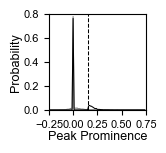

Mean, SEM Real:
0.0472958240195668 0.001072784178337035

Mean, SEM Shuffle:
0.01177437517699742 0.0006628322972218291

stat = 49950.0
p_cells = 6.78924443420472e-219


In [46]:
''' Plot Extended Data Fig. 3C'''
bproms, bin_edges = np.histogram(ngsproms, bins = bins)
pdf = bproms / sum(bproms)

shuffbheights, shuffbin_edges = np.histogram(ngsshuffheights, bins = bins)
shuffpdf = shuffbheights / sum(shuffbheights)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9, labelpad = 1)
ax.set_xlabel('Peak Prominence', fontsize = 9, labelpad = 1)
ax.vlines(0.15,0,0.8, colors ='k', linewidths = 0.75, linestyles = '--')
ax.set_xlim([-0.25,0.75])
ax.set_xticks([-0.25,0,0.25,0.5,0.75])
ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S3C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3C.svg', dpi=400, bbox_inches='tight')
plt.show()

print('Mean, SEM Real:')
print(np.nanmean(ngsproms), stats.sem(ngsproms, nan_policy = 'omit')) 
print('\nMean, SEM Shuffle:')
print(np.nanmean(ngsshuffheights), stats.sem(ngsshuffheights, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngsproms[~np.isnan(ngsshuffheights)], ngsshuffheights[~np.isnan(ngsshuffheights)])
print('\nstat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#Gather Source Data for Extended Data Fig. 3c
#print(list(ngsproms[~np.isnan(ngsproms)]))
#print(list(ngsshuffheights[~np.isnan(ngsshuffheights)]))

In [49]:
'''Calculate Grid vs. NGS Cell Density by Age Group'''
dt = 0.02

# set up arrays for plotting by session 
spergrid = [] 
sperngs = []

# by animal
mpergrid = [] 
mperngs = []

for m, session in zip(mice,sessions):
    
    m_grid = [] 
    m_ngs = []
    m_cells = []

    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #get cell IDs, filtered behavioral/spike data, & relevant score
        gridcell = d['gridcell'].astype(bool)
        ngscell = d['ngscell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscells = cell_IDs[ngscell]
        
        #Calculate Cell Densities
        sperngs = np.append(sperngs, 100 * len(ngscells)/len(cell_IDs))
        spergrid = np.append(spergrid, 100 * len(gridcells)/len(cell_IDs))

        #save data to be pooled by mouse    
        m_grid = np.append(m_grid, len(gridcells)) 
        m_ngs = np.append(m_ngs, len(ngscells)) 
        m_cells = np.append(m_cells, len(cell_IDs))
        
        #Print Source Data for Figure 2d and Extended Data Fig 2d
        #print(str(m) + ',' + str(100 * len(gridcells)/len(cell_IDs)) + ',' + str(100 * len(ngscells)/len(cell_IDs)))
       
    # pool data by animal     
    mpergrid = np.append(mpergrid, 100*np.sum(m_grid)/np.sum(m_cells)) 
    mperngs = np.append(mperngs, 100*np.sum(m_ngs)/np.sum(m_cells)) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

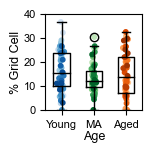


GRID CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
16.17 ± 1.14 ; 13.38 ± 0.79 ; 15.05 ± 1.24
H = 2.5862538000415984
p = 0.27441138320138


In [36]:
'''Grid Cell Density Young vs. Aged Session by Age Group (Figure 2D) + Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
pergrid = [spergrid[y_sind],spergrid[ma_sind],spergrid[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(pergrid, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Grid Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid Cell', fontsize=9, labelpad=1)
ax.set_ylim([0,40])
ax.tick_params(labelsize = 8)

for i in range(len(pergrid)):
    y = pergrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '2D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2D.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nGRID CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(spergrid[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[age_sind]), 2)))

stat, p_diff = stats.kruskal(spergrid[y_sind],spergrid[ma_sind],spergrid[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

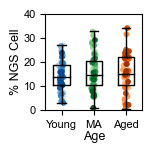


NGS CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
14.59 ± 0.87 ; 15.73 ± 0.95 ; 15.14 ± 1.08
H = 0.4809290162273214
p = 0.7862625508939945


In [37]:
'''NGS Cell Density Young vs. Aged Session by Age Group (Extended Data Fig. 3D) + Stats'''

fig, ax = plt.subplots(figsize = (1.25,1.25))
pergrid = [sperngs[y_sind],sperngs[ma_sind],sperngs[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(pergrid, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% NGS Cell', fontsize=9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,40])

for i in range(len(pergrid)):
    y = pergrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S3D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3D.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nNGS CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperngs[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngs[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngs[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngs[y_sind],sperngs[ma_sind],sperngs[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

  0%|          | 0/6 [00:00<?, ?it/s]

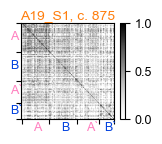

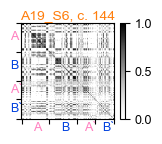

  0%|          | 0/6 [00:00<?, ?it/s]

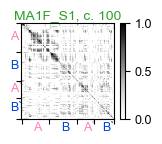

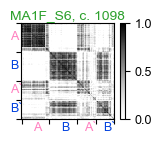

  0%|          | 0/6 [00:00<?, ?it/s]

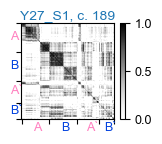

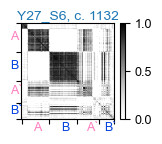

In [47]:
''' Plot example grid cell cross trial correlation matrices (Figure 2E) '''

cellcount = 0

colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue

        d = data[m][s]
    
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    

        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        rawtrialfil = raw.item().get('trialfil')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']

        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []

        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        # add ticks to label contexts dynamically
        lengthdark = (20 - ndarkskipped)
        lengthA = len(numtrial[numtrial < (80 - lengthdark)])
        nA_ = np.sum(1 - leftsort[alltrial >= 140])
        lengthB = len(numtrial[(numtrial >= (80 - lengthdark)) & (numtrial < (140 - lengthdark))])
        lengthA_ = len(numtrial[(numtrial >= (140 - lengthdark)) & (numtrial < (140 + nA_ - lengthdark))])
        end =  len(np.unique(skippedrawtrialfil[:end_idx])) - lengthdark
        nB_ = end - (lengthA + lengthB + lengthA_) 
        
        ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
        textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        c = ex_gridcells[cellcount]
        col = cols[cellcount]
        sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
        sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 

        f = plt.figure(figsize=(1.5, 1.25))
        ax0 = plt.subplot()
        im = ax0.imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys')
        ax0.set_title('{}_S{}, c. {}'.format(m, sesh[cellcount], c), fontsize=10, color = col, pad=3)
        ax0.set_yticks(ticks, labels = [])
        ax0.set_xticks(ticks, labels = [])
        for n, j in enumerate(labels):
            ax0.text(textloc[n] - 5, 225, j, color = colors[n], fontsize = 9)
            ax0.text(-25, textloc[n] + 5, j, color = colors[n], fontsize = 9)
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize = 9)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_2E.png', dpi = 400)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_2E.svg', dpi = 400)
        plt.show()
        
        cellcount += 1 
                                    

  0%|          | 0/6 [00:00<?, ?it/s]

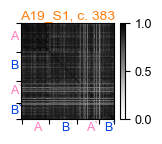

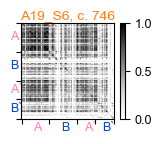

  0%|          | 0/6 [00:00<?, ?it/s]

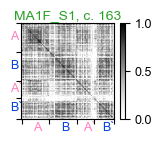

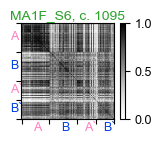

  0%|          | 0/6 [00:00<?, ?it/s]

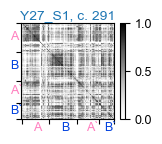

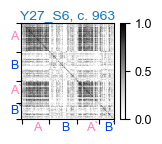

In [48]:
''' Plot example NGS cell cross trial correlation matrices (Extended Data Fig. 3e) '''

cellcount = 0

colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue

        d = data[m][s]
    
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    

        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        rawtrialfil = raw.item().get('trialfil')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']

        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        # add ticks to label contexts dynamically
        lengthdark = (20 - ndarkskipped)
        lengthA = len(numtrial[numtrial < (80 - lengthdark)])
        nA_ = np.sum(1 - leftsort[alltrial >= 140])
        lengthB = len(numtrial[(numtrial >= (80 - lengthdark)) & (numtrial < (140 - lengthdark))])
        lengthA_ = len(numtrial[(numtrial >= (140 - lengthdark)) & (numtrial < (140 + nA_ - lengthdark))])
        end =  len(np.unique(skippedrawtrialfil[:end_idx])) - lengthdark
        nB_ = end - (lengthA + lengthB + lengthA_) 
        
        ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
        textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        c = ex_ngscells[cellcount]
        col = cols[cellcount]
        sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
        sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 

        f = plt.figure(figsize=(1.5, 1.25))
        ax0 = plt.subplot()
        im = ax0.imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys')
        ax0.set_title('{}_S{}, c. {}'.format(m,sesh[cellcount],c), fontsize=10, color = col, pad=3)
        ax0.set_yticks(ticks, labels = [])
        ax0.set_xticks(ticks, labels = [])
        for n, j in enumerate(labels):
            ax0.text(textloc[n] - 5, 225, j, color = colors[n], fontsize = 9)
            ax0.text(-25, textloc[n] + 5, j, color = colors[n], fontsize = 9)
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize = 9)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_S3E.png', dpi = 400)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_S3E.svg', dpi = 400)
        plt.show()
        
        cellcount += 1 
                               

# Examine Grid Cell Stability & Similarity Ratio (Context-Specificity). Plot Figures 2F-I. 

You can skip to this session after setting up and loading in grid cell booleans. 

In [61]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for Grid Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ grid cell number).

'''
for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(gridcells)))
        for i, c in enumerate(gridcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allgridsim'] = allsim
                               
        allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allgridsim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
''' Calculate Local Cross Trial Correlation Stability within Each Context'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#session arrays
slocstab5block = []
slocstab5alt = []

max_k = 5

#cell arrays
ylocstab5block = []
ylocstab5alt = []

malocstab5block = []
malocstab5alt = []

alocstab5block = []
alocstab5alt = []

for m, session in zip(mice, sessions):
    
    for s in session:
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        
        allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        d['allgridsim'] = np.load(save_folder + allgridsim_file)
        allgridsim = d['allgridsim']
        
        local_stabilityblock = [] 
        local_stabilityalt = []
        for i, c in enumerate(gridcells):
            
            #divide sim by context
            sim = allgridsim[:,:,i]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
            
        # Print results for correlation analysis
        #print(str(m) + ',' + str(s[-1]) + ',' + str(np.nanmean(local_stabilityalt)))
            
#save arrays
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

C:\Users\Python\AppData\Local\Temp\ipykernel_21524\2471155963.py:83: RuntimeWarning: Mean of empty slice
  slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
C:\Users\Python\AppData\Local\Temp\ipykernel_21524\2471155963.py:84: RuntimeWarning: Mean of empty slice
  slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))


In [18]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
            
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     6508      Method:               REML         
No. Groups:           29        Scale:                0.0145       
Min. group size:      60        Log-Likelihood:       1847.9229    
Max. group size:      446       Converged:            Yes          
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.332    0.038  8.859 0.000  0.259  0.406
C(AgeGroup)[T.2.0]       -0.112    0.057 -1.966 0.049 -0.223 -0.000
C(AgeGroup)[T.3.0]        0.004    0.045  0.095 0.925 -0.084  0.093
C(Sex)[T.M]               0.025    0.060  0.415 0.678 -0.092  0.141
C(Cohort)[T.D]           -0.012    0.074 -0.157 0.876 -0.156  0

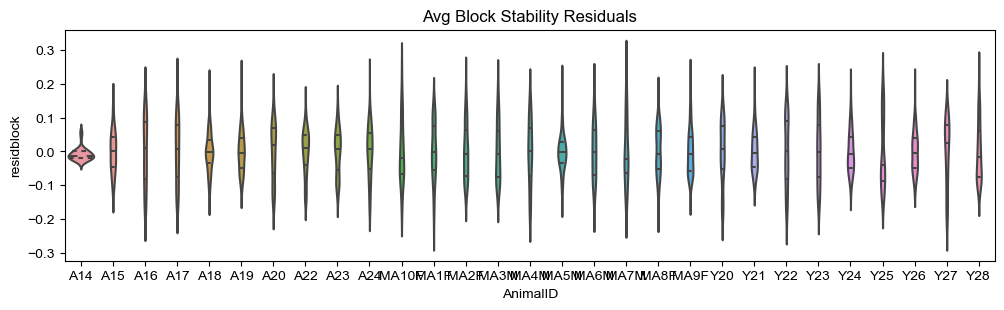

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     6508       Method:                REML       
No. Groups:           29         Scale:                 0.0064     
Min. group size:      60         Log-Likelihood:        4557.4891  
Max. group size:      446        Converged:             Yes        
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.133    0.026  5.147 0.000  0.083  0.184
C(AgeGroup)[T.2.0]       -0.065    0.039 -1.664 0.096 -0.143  0.012
C(AgeGroup)[T.3.0]        0.048    0.031  1.527 0.127 -0.013  0.108
C(Sex)[T.M]               0.031    0.041  0.749 0.454 -0.050  0.112
C(Cohort)[T.D]           -0.016    0.051 -0.308 0.758 -0.116  0

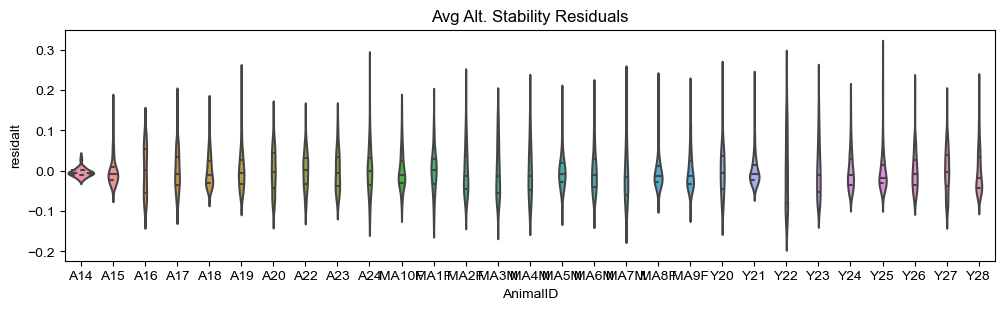

In [33]:
''' LMMs for Moving Avg Similarity [Stability] '''     
#gather dependent variables into lists
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))
residuals = mblock.resid
df['residblock'] = mblock.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mblock.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

# Residuals by Animal
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
residuals = malt.resid
df['residalt'] = malt.resid
#print(malt.aic)
#print(malt.bic)

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(malt.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

# Residuals by Animal
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()

#Collect Fig 2f Source Data
df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure2S3\2f.csv', index = False, header = True)

In [50]:
''' Report Raw & Fitted Alternation Stability by Animal for Figure 8'''

df['fitted'] = malt.fittedvalues
animalgrouped = df.groupby(['AnimalID'])
animal = np.array(animalgrouped['fitted'].mean())

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['locstab5alt'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
#last3mean = df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_numpy()
#first3mean = df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_numpy()
print('Stability First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
print('Stability Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

print('\nRaw Data Mean across All Sessions by Animal:')
#last3mean = df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_numpy()
#first3mean = df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_numpy()
print('Stability First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['locstab5alt'].mean().to_string(index = True))
print('Stability Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['locstab5alt'].mean().to_string(index = True))


Raw Data Mean across All Sessions by Animal:
AnimalID
A14      0.008633
A15      0.106659
A16      0.204171
A17      0.178320
A18      0.105407
A19      0.154642
A20      0.183172
A22      0.207102
A23      0.166900
A24      0.251970
MA10F    0.123812
MA1F     0.237030
MA2F     0.173006
MA3M     0.222019
MA4M     0.145731
MA5M     0.150645
MA6M     0.183956
MA7M     0.203253
MA8F     0.098815
MA9F     0.128382
Y20      0.243152
Y21      0.077495
Y22      0.310607
Y23      0.199210
Y24      0.141264
Y25      0.080733
Y26      0.146082
Y27      0.211913
Y28      0.129100

Fitted Data Mean across All Sessions by Animal:
AnimalID
A14      0.012297
A15      0.106828
A16      0.203478
A17      0.177963
A18      0.105693
A19      0.154661
A20      0.182974
A22      0.206879
A23      0.166787
A24      0.251599
MA10F    0.123951
MA1F     0.236679
MA2F     0.172919
MA3M     0.221729
MA4M     0.146218
MA5M     0.150776
MA6M     0.184036
MA7M     0.202415
MA8F     0.099151
MA9F     0.128450
Y20   

In [20]:
''' Get fitted block vs. alternation grid stability session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 8

n aged, MA, young mice on day 1 for B
10 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 9 9

n aged, MA, young mice on day 4 for B
9 9 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
7 9 9

n aged, MA, young mice on day 6 for B
7 9 9


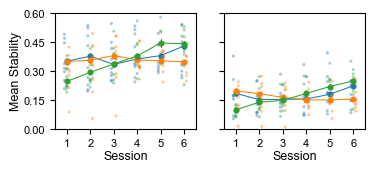

In [21]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure 2f)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6])
ax[0].set_ylim([0.0,0.6])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
ax[1].set_ylim([0.0,0.6])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + '2F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [42]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.13526667581561502 0.6120184615567782 0.6530742190283692 0.48935871987366497
P [Young, MA, Aged, All]: 
0.3341830596715891 4.227366551902729e-07 1.1564708858399309e-07 3.387758863377874e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.10434818856230203 0.6597356193734476 0.4031473313655896 0.4070187001791263
P [Young, MA, Aged, All]: 
0.4571273812819284 2.3825542708744225e-08 0.0027613753821976433 6.976779477876197e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.37947122726324534 0.6587427008462435 0.7127238065191915 0.5832509814659874
P [Young, MA, Aged, All]: 
6.028456161160926e-05 1.633138885836037e-15 1.0444731154622057e-17 4.21381151304087e-31

n session halves: young, ma, aged
106 114 106


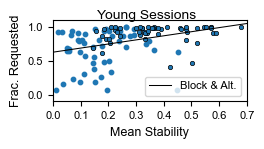

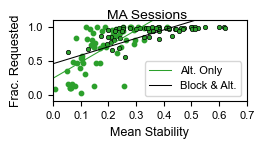

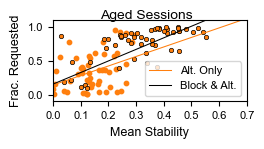

In [23]:
''' Plot Figure 2H with Block & Alt. Data '''
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2Hleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2Hleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2Hmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2Hmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + '2Hright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2Hright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Figure 2h
#print(list(slocstab5block))
#print(list(reqblock_rates))
#print(list(slocstab5alt))
#print(list(reqalt_rates))

In [24]:
''' Check on the confidence interval of the Pearson R Above '''

def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

#Block Alt Stab r-confidence intervals:
yr_stab_lo, yr_stab_hi = r_confidence_interval(0.37947122726324534, 0.05, 106)
mar_stab_lo, mar_stab_hi = r_confidence_interval(0.6587427008462435, 0.05, 114)
ar_stab_lo, ar_stab_hi = r_confidence_interval(0.7127238065191915, 0.05, 106)

print(yr_stab_lo, yr_stab_hi)
print(mar_stab_lo, mar_stab_hi)
print(ar_stab_lo, ar_stab_hi)

#Alt Alone r-confidence intervals
yr_stab_lo, yr_stab_hi = r_confidence_interval(0.10434818856230203, 0.05, 53)
mar_stab_lo, mar_stab_hi = r_confidence_interval(0.6597356193734476, 0.05, 57)
ar_stab_lo, ar_stab_hi = r_confidence_interval(0.4031473313655896, 0.05, 53)

print(yr_stab_lo, yr_stab_hi)
print(mar_stab_lo, mar_stab_hi)
print(ar_stab_lo, ar_stab_hi)

0.20344222269784273 0.5317362760099741
0.5402847667131965 0.7515993391091504
0.6040992683361162 0.7953470728483936
-0.17076190657784845 0.3643652004238062
0.48203205113469566 0.785304846059198
0.1491007657775096 0.6072682027675286


In [25]:
''' [Optional] Verify that findings replicate in subsample of sequenced Split Maze mice'''

seqsample_mice = ['Y22','Y27','MA1F','MA3M','A18','A19','Y23','Y25','MA8F','MA6M','A15','A22','Y20','Y28','MA10F','MA5M','A24','A17']

y_sind_sub = []
ma_sind_sub = []
age_sind_sub = []

total_sesh = 0
for m, session in zip(mice,sessions):    
    for s in session:
        
        if m in seqsample_mice:
            if m in SM_aged_mice:
                age_sind_sub = np.append(age_sind_sub,total_sesh)
            elif m in SM_MA_mice:
                ma_sind_sub = np.append(ma_sind_sub,total_sesh)
            else:
                y_sind_sub = np.append(y_sind_sub,total_sesh)
                
            total_sesh += 1
        else:
            
            total_sesh += 1
            
            continue 
            
y_sind_sub = y_sind_sub.astype(int)
ma_sind_sub = ma_sind_sub.astype(int)
age_sind_sub = age_sind_sub.astype(int)

y_sindgrid_sub = np.intersect1d(y_sindgrid,y_sind_sub)
ma_sindgrid_sub = np.intersect1d(ma_sindgrid,ma_sind_sub)
age_sindgrid_sub = np.intersect1d(age_sindgrid,age_sind_sub)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.189949336610591 0.5053215832258462 0.48671234069739255 0.3884743563768554
P [Young, MA, Aged, All]: 
0.2744238282468727 0.0016691395256720472 0.00302801784439132 3.87190592838075e-05

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.21193176701909183 0.7105417639641318 0.38083184528747344 0.4549345532080377
P [Young, MA, Aged, All]: 
0.22162740430362124 1.2036417403416075e-06 0.024007041220624303 9.61868362706427e-07

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4303508419723944 0.6483860059697665 0.6671342158613451 0.5794573600952321
P [Young, MA, Aged, All]: 
0.00020042135085067086 7.369238298081498e-10 2.8615336622422905e-10 2.0735422733288094e-20

n session halves: young, ma, aged
70 72 70


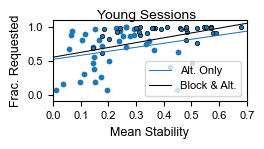

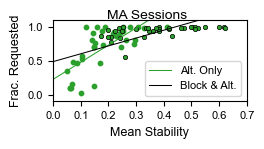

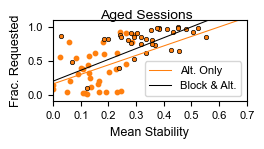

In [26]:
''' Plot Figure 2H with Block & Alt. Data [Subsample Sequenced Mice] '''
allidx = np.concatenate((y_sindgrid_sub, ma_sindgrid_sub, age_sindgrid_sub))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid_sub],slocstab5alt[y_sindgrid_sub])),np.hstack((reqblock_rates[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid_sub],slocstab5alt[ma_sindgrid_sub])),np.hstack((reqblock_rates[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid_sub],slocstab5alt[age_sindgrid_sub])),np.hstack((reqblock_rates[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid_sub)*2,len(ma_sindgrid_sub)*2,len(age_sindgrid_sub)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.show()

In [35]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = [] # context specificity during block phase
sA_B_ratio = [] # context specificity duing alt. phase
sAB_ratio = [] # context specificity during alt. phase wrt to block phase spatial firing

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allgridsim = d['allgridsim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(gridcells):
            sim = allgridsim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio = np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))
        
        # Print results for correlation analysis
        #print(str(m) + ',' + str(s[-1]) + ',' + str(np.nanmean(AB_ratio)))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_21524\1431380756.py:83: RuntimeWarning: Mean of empty slice
  sABratio = np.append(sABratio, np.nanmean(ABratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_21524\1431380756.py:84: RuntimeWarning: Mean of empty slice
  sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_21524\1431380756.py:85: RuntimeWarning: Mean of empty slice
  sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ABratio  
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0333   
Min. group size:      60          Log-Likelihood:         -984.5730
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.193    0.052 23.064 0.000  1.091  1.294
C(AgeGroup)[T.2.0]       -0.108    0.078 -1.375 0.169 -0.261  0.046
C(AgeGroup)[T.3.0]        0.060    0.062  0.962 0.336 -0.062  0.183
C(Sex)[T.M]              -0.033    0.082 -0.405 0.685 -0.193  0.127
C(Cohort)[T.D]            0.058    0.101  0.577 0.564 -0.140  0

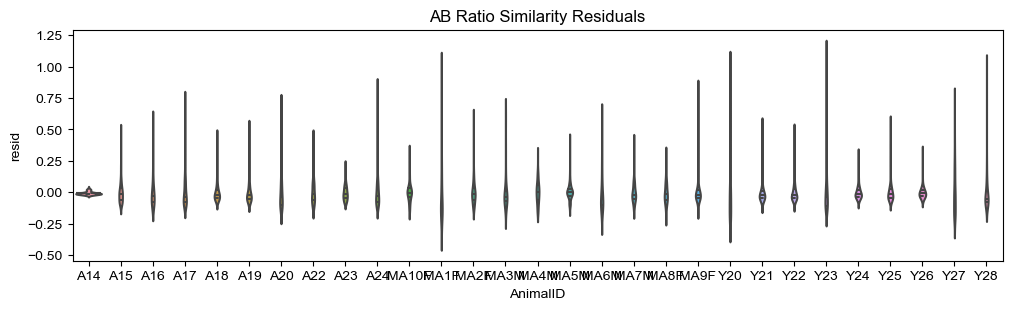

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     A_B_ratio
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0020   
Min. group size:      60          Log-Likelihood:         8178.5048
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.000    0.012 83.325 0.000  0.977  1.024
C(AgeGroup)[T.2.0]        0.003    0.018  0.156 0.876 -0.033  0.038
C(AgeGroup)[T.3.0]        0.054    0.015  3.705 0.000  0.025  0.082
C(Sex)[T.M]              -0.001    0.019 -0.055 0.956 -0.038  0.036
C(Cohort)[T.D]            0.017    0.023  0.734 0.463 -0.029  0

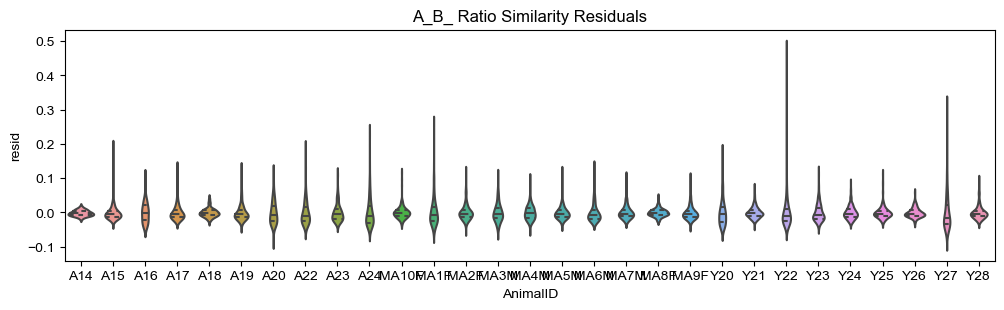

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     AB_ratio 
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0026   
Min. group size:      60          Log-Likelihood:         7102.5751
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.003    0.012 83.859 0.000  0.979  1.026
C(AgeGroup)[T.2.0]        0.011    0.018  0.632 0.527 -0.024  0.047
C(AgeGroup)[T.3.0]        0.037    0.015  2.556 0.011  0.009  0.066
C(Sex)[T.M]              -0.012    0.019 -0.659 0.510 -0.049  0.024
C(Cohort)[T.D]            0.010    0.023  0.413 0.679 -0.036  0

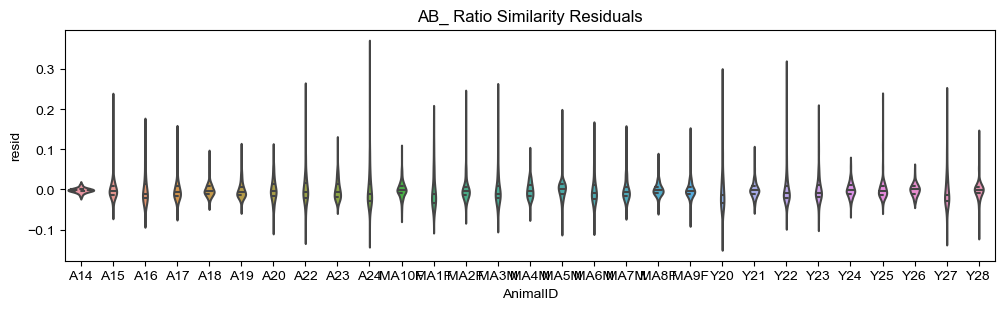

In [37]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))
residuals = mAB.resid
df['resid'] = mAB.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mAB.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))
#print(mAB_.aic)
#print(mAB_.bic)

residuals = mAB_.resid
df['resid'] = mAB_.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mAB_.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

#Collect Fig 2g Source Data
df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure2S3\2g.csv', index = False, header = True)

In [27]:
''' Report Grid Alt. Sim Ratio by Animal for Figure 8 '''

df['mAB_fitted'] = mAB_.fittedvalues
animalgrouped = df.groupby(['AnimalID'])
animal = np.array(animalgrouped['mAB_fitted'].mean())

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['AB_ratio'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['mAB_fitted'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print('Sim Ratio First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['mAB_fitted'].mean().to_string(index = True))
print('Sim Ratio Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['mAB_fitted'].mean().to_string(index = True))

print('\nRaw Data Mean across All Sessions by Animal:')
print('First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['AB_ratio'].mean().to_string(index = True))
print('Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['AB_ratio'].mean().to_string(index = True))

Raw Data Mean across All Sessions by Animal:
AnimalID
A14      1.003322
A15      1.015189
A16      1.074426
A17      1.046459
A18      1.029614
A19      1.030421
A20      1.028109
A22      1.050725
A23      1.058265
A24      1.084814
MA10F    1.026659
MA1F     1.114507
MA2F     1.042239
MA3M     1.064096
MA4M     1.019832
MA5M     0.990396
MA6M     1.058316
MA7M     1.042231
MA8F     1.028074
MA9F     1.027620
Y20      1.112621
Y21      1.023652
Y22      1.066727
Y23      1.044190
Y24      1.026441
Y25      1.026163
Y26      1.016858
Y27      1.067311
Y28      1.011710

Fitted Data Mean across All Sessions by Animal:
AnimalID
A14      1.005120
A15      1.015427
A16      1.073413
A17      1.046436
A18      1.029791
A19      1.030579
A20      1.028368
A22      1.050595
A23      1.057936
A24      1.084429
MA10F    1.026897
MA1F     1.113879
MA2F     1.042337
MA3M     1.063566
MA4M     1.020234
MA5M     0.990887
MA6M     1.057961
MA7M     1.041620
MA8F     1.028320
MA9F     1.027784
Y20   

In [28]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 8

n aged, MA, young mice on day 1 for alt ratio
10 10 8

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
9 10 9

n aged, MA, young mice on day 3 for alt ratio
9 10 9

n aged, MA, young mice on day 4 for block ratio
9 9 9

n aged, MA, young mice on day 4 for alt ratio
9 9 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
7 9 9

n aged, MA, young mice on day 6 for alt ratio
7 9 9


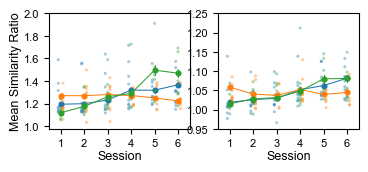

In [29]:
'''Plot Figure 2G '''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.2,1.4,1.6,1.8,2])
ax[0].set_ylim([0.975,2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0.95,1,1.05,1.1,1.15,1.2,1.25])
ax[1].set_ylim([0.95,1.25])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + '2G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2G.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2819098716114151 0.44975468866069823 0.5719928588345101 0.407733990717708
P [Young, MA, Aged, All]: 
0.0408469763298259 0.000448258985355836 7.666811942748772e-06 6.584353053540282e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4750354658195049 0.4211135331368788 0.36748220836874496 0.4226559249969857
P [Young, MA, Aged, All]: 
0.00032537594142593003 0.0011061507435268301 0.006790526549380011 1.9072332021089063e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4677034814812488 0.46506962825123216 0.6779211550229156 0.5108719812706851
P [Young, MA, Aged, All]: 
4.3053109456702697e-07 1.856473615665398e-07 1.440992194092544e-15 4.525432085568733e-23

n session halves: young, ma, aged
106 114 106


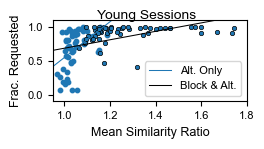

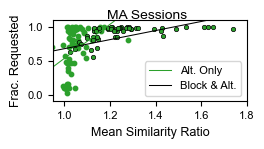

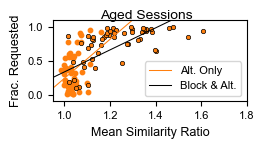

In [30]:
''' Plot Figure 2I '''

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindgrid],sAB_ratio[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindgrid],sAB_ratio[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindgrid],sAB_ratio[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2Ileft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2Ileft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2Imiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2Imiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + '2Iright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2Iright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Figure 2I
#print(list(sABratio))
#print(list(reqblock_rates))
#print(list(sAB_ratio))
#print(list(reqalt_rates))

In [31]:
''' Check Confidence Intervals '''

#Block Alt Sim Ratio r-confidence intervals:
yr_stab_lo, yr_stab_hi = r_confidence_interval(0.4677034814812488, 0.05, 106)
mar_stab_lo, mar_stab_hi = r_confidence_interval(0.46506962825123216, 0.05, 114)
ar_stab_lo, ar_stab_hi = r_confidence_interval(0.6779211550229156, 0.05, 106)

print(yr_stab_lo, yr_stab_hi)
print(mar_stab_lo, mar_stab_hi)
print(ar_stab_lo, ar_stab_hi)

#Alt Alone r-confidence intervals
yr_stab_lo, yr_stab_hi = r_confidence_interval(0.4750354658195049, 0.05, 53)
mar_stab_lo, mar_stab_hi = r_confidence_interval(0.4211135331368788, 0.05, 57)
ar_stab_lo, ar_stab_hi = r_confidence_interval(0.36748220836874496, 0.05, 53)

print(yr_stab_lo, yr_stab_hi)
print(mar_stab_lo, mar_stab_hi)
print(ar_stab_lo, ar_stab_hi)

0.3040768881718076 0.6045250041479292
0.3074521920816929 0.5978485388466659
0.5595214507708056 0.7692051634970823
0.2349029984444717 0.660519178745722
0.18033362719128454 0.6142774099158901
0.10790655688990573 0.5801507134333553



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3565644348161827 0.3796679605740946 0.4583486469811562 0.407733990717708
P [Young, MA, Aged, All]: 
0.03550799245916843 0.022378471476769607 0.005622021422983838 6.584353053540282e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5930358290785688 0.4240625668127706 0.3157002865781926 0.4226559249969857
P [Young, MA, Aged, All]: 
0.00017384211459259795 0.00995182986064081 0.06468299996035495 1.9072332021089063e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5203753673167092 0.4361390110244973 0.6471624387501961 0.5130787699085234
P [Young, MA, Aged, All]: 
3.884839019648997e-06 0.00012834146488577443 1.4171875425877751e-09 1.2393623740390105e-15

n session halves: young, ma, aged
70 72 70


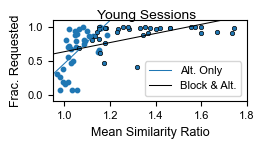

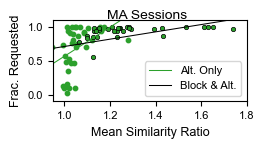

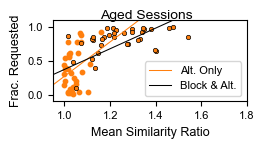

In [47]:
'''[Optional] Verify the relationship of grid similarity ratio in sequenced subsample of mice'''

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindgrid_sub],sAB_ratio[y_sindgrid_sub])),np.hstack((reqblock_rates[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindgrid_sub],sAB_ratio[ma_sindgrid_sub])),np.hstack((reqblock_rates[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindgrid_sub],sAB_ratio[age_sindgrid_sub])),np.hstack((reqblock_rates[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid_sub, ma_sindgrid_sub, age_sindgrid_sub))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid_sub)*2,len(ma_sindgrid_sub)*2,len(age_sindgrid_sub)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.show()

# NGS Cell Stability, Context-Matched Similarity, & Similarity Ratio

Figures S3F - I. You can skip to this session after setting up and loading in NGS cell booleans. 

In [86]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for NGS Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ NGS cell number).

'''

for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
    
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(ngscells)))
        for i, c in enumerate(ngscells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allngssim'] = allsim
                               
        allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allngssim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
''' Calculate Local Cross Trial Correlation Stability within Each Context & for Block vs. Alt Phases'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#adjust loading folder path to match output of cell above
slocstab5block = []
slocstab5alt = []

max_k = 5

#cell arrays
ylocstab5block = []
ylocstab5alt = []
malocstab5block = []
malocstab5alt = []
alocstab5block = []
alocstab5alt = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx']
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        d['allngssim'] = np.load(save_folder + allngssim_file)
        allsim = d['allngssim']
        
        local_stabilityblock = [] 
        local_stabilityalt = []
        
        for i, c in enumerate(ngscells):
            
            #divide sim by context
            sim = allsim[:,:,i]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 

#save arrays
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [39]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     6559      Method:               REML         
No. Groups:           29        Scale:                0.0116       
Min. group size:      65        Log-Likelihood:       2019.0985    
Max. group size:      446       Converged:            Yes          
Mean group size:      226.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.250    0.020 12.604 0.000  0.211  0.289
C(AgeGroup)[T.2.0]       -0.036    0.030 -1.216 0.224 -0.094  0.022
C(AgeGroup)[T.3.0]        0.038    0.025  1.561 0.119 -0.010  0.087
C(Sex)[T.M]               0.040    0.029  1.368 0.171 -0.017  0.098
C(Cohort)[T.D]           -0.029    0.037 -0.803 0.422 -0.101  0

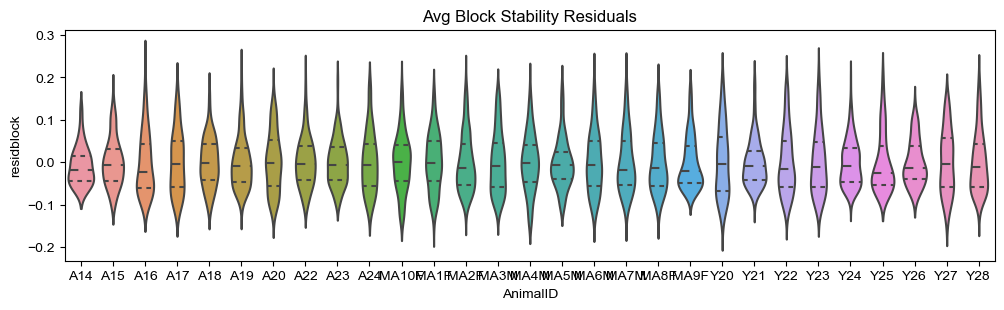

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     6559       Method:                REML       
No. Groups:           29         Scale:                 0.0067     
Min. group size:      65         Log-Likelihood:        3889.8650  
Max. group size:      446        Converged:             Yes        
Mean group size:      226.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.122    0.016  7.453 0.000  0.090  0.154
C(AgeGroup)[T.2.0]       -0.035    0.024 -1.437 0.151 -0.083  0.013
C(AgeGroup)[T.3.0]        0.033    0.020  1.629 0.103 -0.007  0.072
C(Sex)[T.M]               0.031    0.025  1.245 0.213 -0.018  0.079
C(Cohort)[T.D]           -0.017    0.030 -0.570 0.569 -0.077  0

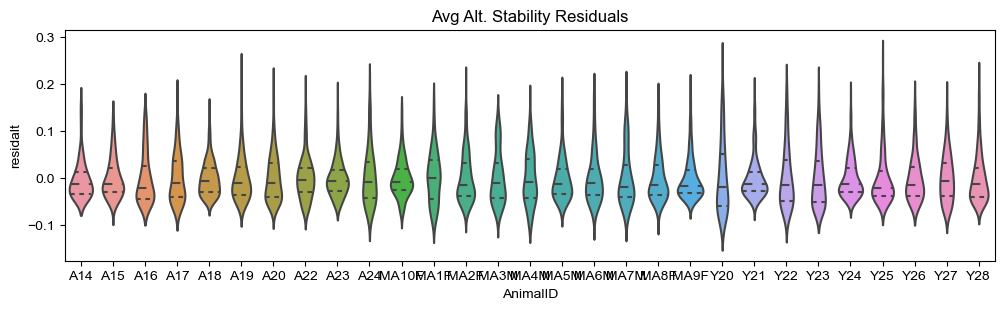

In [44]:
''' LMMs for NGS Cell Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

residuals = mblock.resid
df['residblock'] = mblock.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mblock.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
residuals = malt.resid
df['residalt'] = malt.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(malt.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()

#Collect Extended Data Fig 3f Source Data
df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure2S3\S3f.csv', index = False, header = True)

In [66]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


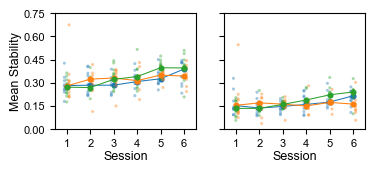

In [67]:
''' Composite Plot of Block & Alternation Stability w/ Fitted Session Average Data Points (Extended Data Fig. 3F)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[0].set_ylim([0.0,0.75])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[1].set_ylim([0.0,0.75])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S3F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [68]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.23147493821136603 0.5886230366289212 0.5502717239316673 0.4325718228014446
P [Young, MA, Aged, All]: 
0.09537232106918653 1.4663780506615417e-06 1.967270647844219e-05 5.2854740923709765e-09

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.18245609313185213 0.6436944876753999 0.4154894548712481 0.39689885145295833
P [Young, MA, Aged, All]: 
0.19099731307388595 6.623890256304558e-08 0.001975705664020459 1.0944789594419273e-07

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4496502518120779 0.6518191034820533 0.6597893383907855 0.5750661092443902
P [Young, MA, Aged, All]: 
1.3289348398301994e-06 4.019716587856845e-15 1.450294831417669e-14 4.309473351107204e-30

n session halves: young, ma, aged
106 114 106


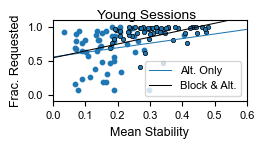

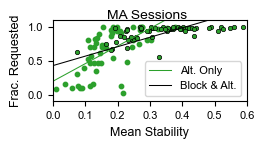

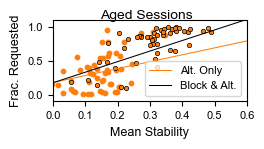

In [70]:
''' Plot Extended Data Fig. 3H '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[~np.isnan(slocstab5block)],reqblock_rates[~np.isnan(slocstab5block)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[~np.isnan(slocstab5alt)],reqalt_rates[~np.isnan(slocstab5alt)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))
res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.6])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3Hleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3Hleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.6])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3Hmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3Hmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.6])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'S3Hright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3Hright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Extended Data Figure 3h
#print(list(slocstab5block))
#print(list(reqblock_rates))
#print(list(slocstab5alt))
#print(list(reqalt_rates))

In [45]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allngssim = d['allngssim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(ngscells):
            sim = allngssim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     ABratio 
No. Observations:      6559        Method:                 REML    
No. Groups:            29          Scale:                  0.0170  
Min. group size:       65          Log-Likelihood:         755.6985
Max. group size:       446         Converged:              Yes     
Mean group size:       226.2                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.102    0.024 46.716 0.000  1.056  1.149
C(AgeGroup)[T.2.0]        0.010    0.035  0.296 0.767 -0.058  0.079
C(AgeGroup)[T.3.0]        0.059    0.029  2.008 0.045  0.001  0.117
C(Sex)[T.M]              -0.012    0.035 -0.337 0.736 -0.080  0.057
C(Cohort)[T.D]            0.036    0.043  0.843 0.399 -0.048  0

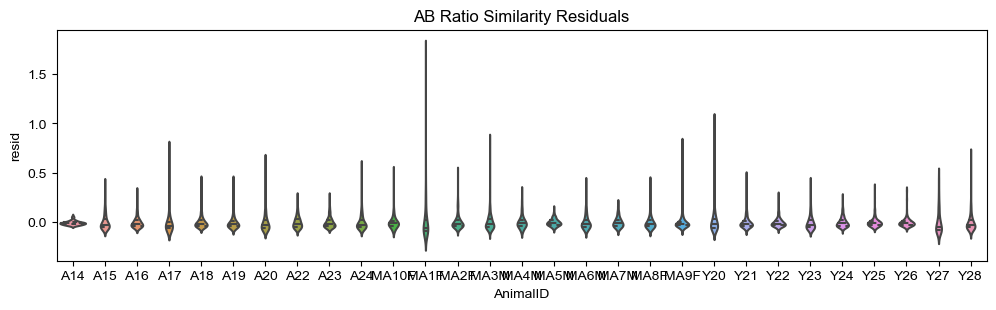

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     A_B_ratio
No. Observations:      6559        Method:                 REML     
No. Groups:            29          Scale:                  0.0010   
Min. group size:       65          Log-Likelihood:         9292.5559
Max. group size:       446         Converged:              Yes      
Mean group size:       226.2                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.011    0.007 146.390 0.000  0.998  1.025
C(AgeGroup)[T.2.0]        0.002    0.010   0.193 0.847 -0.018  0.022
C(AgeGroup)[T.3.0]        0.027    0.009   3.205 0.001  0.011  0.044
C(Sex)[T.M]              -0.002    0.010  -0.206 0.837 -0.022  0.018
C(Cohort)[T.D]            0.011    0.013   0.854 0

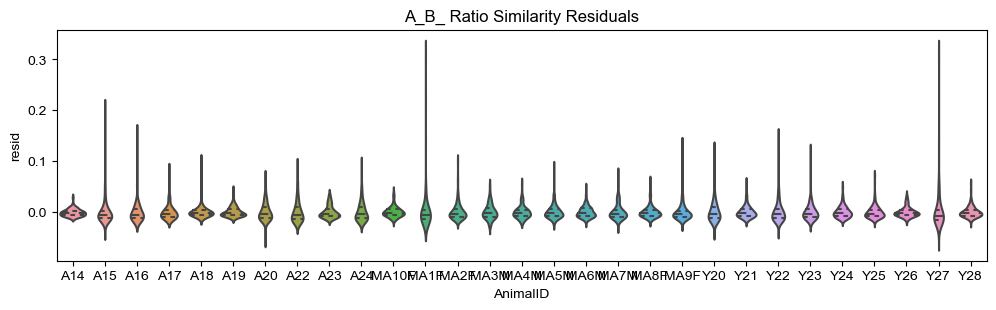

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     AB_ratio 
No. Observations:      6559        Method:                 REML     
No. Groups:            29          Scale:                  0.0018   
Min. group size:       65          Log-Likelihood:         8093.0795
Max. group size:       446         Converged:              Yes      
Mean group size:       226.2                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.016    0.008 133.591 0.000  1.001  1.031
C(AgeGroup)[T.2.0]        0.008    0.011   0.701 0.483 -0.014  0.030
C(AgeGroup)[T.3.0]        0.009    0.009   0.993 0.321 -0.009  0.028
C(Sex)[T.M]              -0.008    0.011  -0.720 0.471 -0.030  0.014
C(Cohort)[T.D]            0.004    0.014   0.288 0

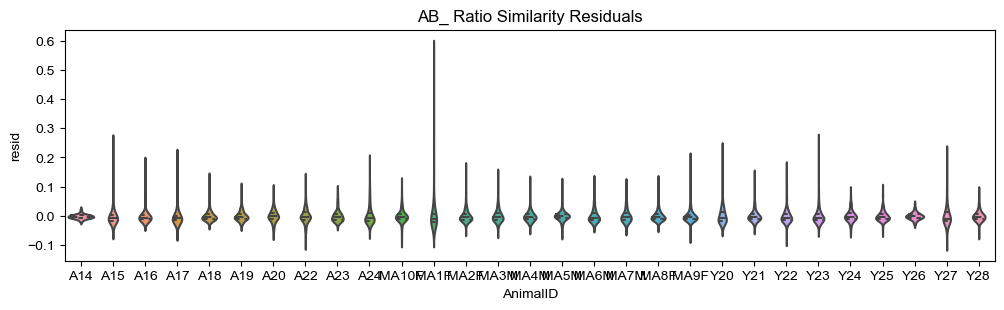

In [48]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

residuals = mAB.resid
df['resid'] = mAB.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mAB.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

#plot residuals
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
#mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     #data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

residuals = mAB_.resid
df['resid'] = mAB_.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mAB_.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

#Collect Extended Data Fig 3g Source Data
df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure2S3\S3g.csv', index = False, header = True)

In [73]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 9

n aged, MA, young mice on day 1 for alt ratio
10 10 9

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
10 10 9

n aged, MA, young mice on day 3 for alt ratio
10 10 9

n aged, MA, young mice on day 4 for block ratio
9 10 9

n aged, MA, young mice on day 4 for alt ratio
9 10 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
8 9 9

n aged, MA, young mice on day 6 for alt ratio
8 9 9


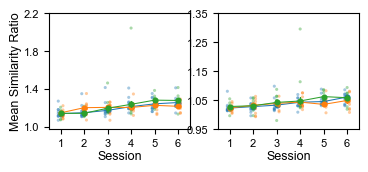

In [74]:
'''Plot Extended Data Fig. 3G '''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.4,1.8,2.2])
ax[0].set_ylim([0.975,2.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0.95,1.05,1.15,1.25,1.35])
ax[1].set_ylim([0.95,1.35])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S3G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3G.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3893391243173612 0.36874504023109245 0.6522506106051179 0.3915512286955412
P [Young, MA, Aged, All]: 
0.003615741807794011 0.004395844935643074 6.851912609075353e-08 1.6732953259645066e-07

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.49047742741880634 0.3606598913879203 0.4272745170720656 0.40104725747047365
P [Young, MA, Aged, All]: 
0.00016649569388333817 0.00541609385272374 0.001139946829641616 7.833062954578497e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5256018423327483 0.4162597292600616 0.7388355360932362 0.5118202282407499
P [Young, MA, Aged, All]: 
5.1951307136984235e-09 3.3612032789572954e-06 3.160597442656295e-20 1.0705466191525518e-23

n session halves: young, ma, aged
108 116 110


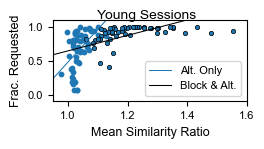

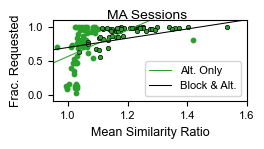

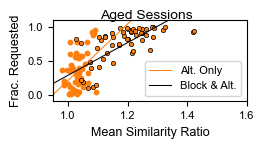

In [76]:
''' Plot Extended Data Fig. 3I '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindngs],sAB_ratio[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindngs],sAB_ratio[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindngs],sAB_ratio[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue; ap3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3Ileft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3Ileft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3Imiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3Imiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6,])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'S3Iright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3Iright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Extended Data Figure 3i
#print(list(sABratio))
#print(list(reqblock_rates))
#print(list(sAB_ratio))
#print(list(reqalt_rates))